In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
folder_path = '../input/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from numba import jit
from sklearn import metrics
import lightgbm as lgb
import time
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [4]:
train_df = train.sort_values('TransactionDT').loc[:472432,:].reset_index(drop = True)
test_df = train.sort_values('TransactionDT').loc[472432:,:].reset_index(drop = True)

In [5]:
del train_identity, train_transaction

In [ ]:
train_df

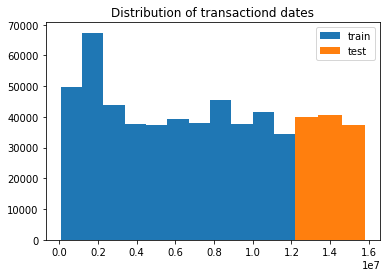

In [10]:
plt.hist(train_df['TransactionDT'], label='train', bins = 11);
plt.hist(test_df['TransactionDT'], label='test', bins = 3);
plt.legend();
plt.title('Distribution of transactiond dates');

In [26]:
train['isFraud'].value_counts(normalize = True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [14]:
null_df = (train.isna().sum()/len(train)).to_frame().reset_index()
for i in range(10):
    print(np.mean(null_df[0]> i*0.1), i*0.1)


0.9539170506912442 0.0
0.7419354838709677 0.1
0.5806451612903226 0.2
0.5345622119815668 0.30000000000000004
0.5345622119815668 0.4
0.4930875576036866 0.5
0.4792626728110599 0.6000000000000001
0.4792626728110599 0.7000000000000001
0.17050691244239632 0.8
0.027649769585253458 0.9


In [15]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472428,3459428,0,12192736,49.000,W,17188,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472429,3459429,0,12192742,40.000,H,16659,170.0,150.0,visa,226.0,...,chrome 65.0,24.0,1440x900,match_status:2,T,F,T,T,desktop,MacOS
472430,3459430,0,12192743,15.000,W,7919,194.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472431,3459431,0,12192842,49.000,W,13749,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
many_null_cols = [col for col in train_df.columns if train_df[col].isnull().sum() / train_df.shape[0] > 0.9]
many_null_cols_test = [col for col in test_df.columns if test_df[col].isnull().sum() / test_df.shape[0] > 0.9]

print(f'{len(set(many_null_cols+ many_null_cols_test)) / train_df.shape[1]: .4f} % columns have more than 90% NaN values')


# Getting columns with single value appearing more than 90% of time

big_top_value_cols = [col for col in train_df.columns if train_df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test_df.columns if test_df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

print(f'{len(set(big_top_value_cols+ big_top_value_cols_test)) / train_df.shape[1]: .4f} % columns have more than 90% same values')


# Getting columns with no unique values

one_value_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]
one_value_cols_test = [col for col in test_df.columns if test_df[col].nunique() <= 1]

print(f'{len(set(one_value_cols+ one_value_cols_test))} columns have only 1 value')


cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
print(len(cols_to_drop))

train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

# Making a list of all categorical columns

cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
 

for col in cat_cols:
    if col in train_df.columns:
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))  

X = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_df.sort_values('TransactionDT')['isFraud']

 0.0369 % columns have more than 90% NaN values
 0.1797 % columns have more than 90% same values
1 columns have only 1 value
77


In [8]:
y_test = test_df['isFraud']
X_test = test_df.drop(['TransactionDT', 'TransactionID', 'isFraud'], axis=1)

In [9]:
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


In [10]:
def callibrate_model(model, X_valid, y_valid, X_test):
    isotonic_rf = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
    isotonic_rf.fit(X_valid, y_valid)
    calibrated_yhat = isotonic_rf.predict_proba(X_test)
    return calibrated_yhat[:,1]

In [11]:
def run_lgbm(X, y, X_test, y_test, n_fold, params):
    folds = KFold(n_splits=n_fold)
    columns = X.columns
    oof = np.zeros((len(X), 1))
    prediction = np.zeros((len(X_test), 1))
    cali_prediction = np.zeros((len(X_test), 1))

    scores = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.LGBMClassifier(**params, n_estimators=5000, n_jobs = -1)
        model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=eval_auc,
                        verbose=500, early_stopping_rounds=200)
                
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
        
        
        oof[valid_index] = y_pred_valid.reshape(-1, 1)
        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))
        print(f'testing auc: {metrics.roc_auc_score(y_test, y_pred): .6f}')
        
        cali_y_pred = callibrate_model(model, X_valid, y_valid, X_test)
        
        prediction += y_pred.reshape(-1, 1)
        cali_prediction += cali_y_pred.reshape(-1, 1)
        
    prediction /= n_fold
    cali_prediction /= n_fold
    result_dict = {}
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['cali_prediction'] = cali_prediction
    
    return result_dict

In [12]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9
         }

lgbm_result = run_lgbm(X, y, X_test, y_test, 5, params)

Fold 1 started at Sun Dec 11 06:03:49 2022
[500]	training's auc: 0.994472	training's auc: 0.994472	valid_1's auc: 0.924986	valid_1's auc: 0.924986
testing auc:  0.922300
Fold 2 started at Sun Dec 11 06:08:23 2022
[500]	training's auc: 0.995501	training's auc: 0.995501	valid_1's auc: 0.935629	valid_1's auc: 0.935629
testing auc:  0.922533
Fold 3 started at Sun Dec 11 06:13:43 2022
[500]	training's auc: 0.994756	training's auc: 0.994756	valid_1's auc: 0.940899	valid_1's auc: 0.940899
testing auc:  0.920941
Fold 4 started at Sun Dec 11 06:18:42 2022
[500]	training's auc: 0.995885	training's auc: 0.995885	valid_1's auc: 0.927087	valid_1's auc: 0.927087
testing auc:  0.916000
Fold 5 started at Sun Dec 11 06:22:22 2022
testing auc:  0.902790


In [13]:
auc = metrics.roc_auc_score(y_test, lgbm_result['cali_prediction'])
print(f'testing auc: {auc: .4f}')
auc = metrics.roc_auc_score(y_test, lgbm_result['prediction'])
print(f'testing auc: {auc: .4f}')

# print(f'testing auc: {metrics.roc_auc_score(y_test[:10000], lgbm_result['prediction']): .6f}')

testing auc:  0.9252
testing auc:  0.9253


In [14]:
def plot_calibration_curve(y_test, y_pred, cali_y_pred,bins = 10):
    brier_loss  = metrics.brier_score_loss(y_test, y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'uncalibrated - {brier_loss: .4f}', color = 'orange')
    
    brier_loss  = metrics.brier_score_loss(y_test, cali_y_pred)
    fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, cali_y_pred, n_bins=bins)
    plt.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label=f'calibrated - {brier_loss: .4f}', color = 'green')
    
    plt.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
    
    plt.legend()

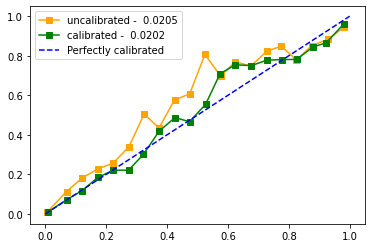

In [28]:
plot_calibration_curve(y_test, lgbm_result['prediction'], lgbm_result['cali_prediction'], 20)

In [26]:
def compute_agg_table(rs_df, q, q_col):
    rs_df.quantile(q).loc[:,'pred_prob']
    all_cutoffs = rs_df.quantile(q).loc[:,q_col]

    total_fraud = sum(rs_df['fraud'])


    n_perc = []
    n_fraud = []
    money_saved = []
    p_fraud = []
    false_pos = []
    p_cutoff = []

    for perc, cutoff in zip(all_cutoffs.index, all_cutoffs.values):
    
        pos_mask = rs_df[q_col] >= cutoff
    
        pos_df = rs_df[pos_mask]
        
        n_perc.append(perc)
        n_fraud.append(sum(pos_df['fraud']))
        money_saved.append(sum(pos_df['fraud'] * pos_df['transaction_amount']))
        p_fraud.append(sum(pos_df['fraud']) / total_fraud)
        false_pos.append(len(pos_df) - sum(pos_df['fraud']))
        p_cutoff.append(cutoff)

    agg_df = pd.DataFrame()
    agg_df['percentile'] = n_perc
    agg_df['cutoff'] = p_cutoff
    agg_df['no_of_fraud'] = n_fraud
    agg_df['fraud_money_value'] = money_saved
    agg_df['total_amount'] = [sum(rs_df['transaction_amount'])] * len(n_perc)
    agg_df['percent_fraud'] = p_fraud
    agg_df['u_2fa'] = false_pos
    
    return agg_df


def generate_result_table(cali_y_pred, y_pred,X, y, q = np.array(range(75,100))/100, q_col = 'pred_prob'):
    result_df = pd.DataFrame()
    result_df['fraud'] = y
    result_df['transaction_amount'] = X['TransactionAmt']
    result_df['pred_prob'] = cali_y_pred
    result_df['risk'] = result_df['transaction_amount'] * result_df['pred_prob']
    result_df['uncalibrated_pred_prob'] = y_pred
    
    agg_df = compute_agg_table(result_df, q, q_col)

    return result_df, agg_df
    

In [27]:
rs_df, ag_df = generate_result_table(lgbm_result['cali_prediction'], lgbm_result['prediction'], X_test, y_test)

In [18]:
rs_df.to_csv('rs_lgbm.csv', index=False)
ag_df.to_csv('ag_lgbm.csv', index=False)

In [25]:
rs_df['uncalibrated_pred_prob'] = lgbm_result['prediction']
rs_df.to_csv('lgbm_output.csv', index = False)